### Imports


In [14]:
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import os

### Data Verkrijgen

Found 162 files belonging to 3 classes.


Using 146 files for training.
Found 162 files belonging to 3 classes.
Using 16 files for validation.
Found 18 files belonging to 3 classes.


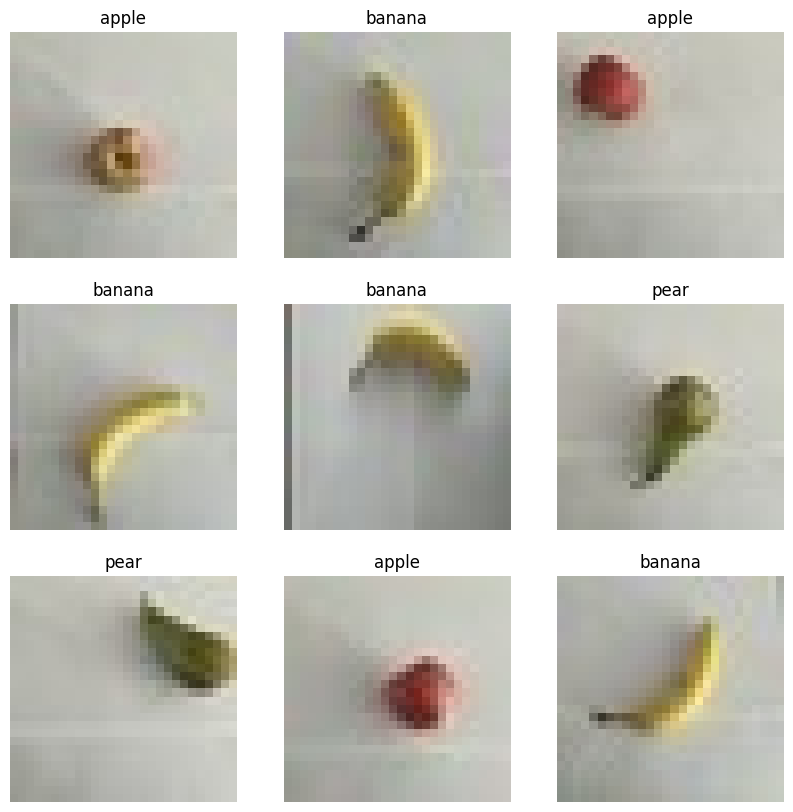

In [15]:
img_height = 28
img_width = 28
batch_size = 10

# Definieer de datasets
ds_train = tf.keras.utils.image_dataset_from_directory(
    'FruitImages',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    labels='inferred',
    label_mode='int',
    color_mode='rgb',
    class_names=['apple', 'banana', 'pear'],
    shuffle=True,
    seed=123,
    validation_split=0.1,  # 20% wordt gereserveerd voor validatie + test
    subset='training'
)

ds_validation = tf.keras.utils.image_dataset_from_directory(
    'FruitImages',
    labels='inferred',
    label_mode='int',
    color_mode='rgb',
    class_names=['apple', 'banana', 'pear'],
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split=0.1,
    subset='validation'
)

ds_test = tf.keras.utils.image_dataset_from_directory(
    'FruitImagesTest',
    labels='inferred',
    label_mode='int',
    color_mode='rgb',
    class_names=['apple', 'banana', 'pear'],
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True, 
    seed=123,
)


# print one image with label
class_names = ['apple', 'banana', 'pear']
plt.figure(figsize=(10, 10))
for images, labels in ds_train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Model Maken

In [16]:
print("=====================================")
print("Model maken en trainen")


model_path = 'Model/Model.h5'

# Controleer of het opgeslagen model bestaat
if os.path.exists(model_path):
    print(f"Laden van opgeslagen model: {model_path}")
    model = tf.keras.models.load_model(model_path)
else:
    print("Opnieuw maken van model")
    model = tf.keras.models.Sequential([
        tf.keras.layers.Rescaling(1./255),
        tf.keras.layers.Conv2D(32, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(32, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(32, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(3, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.fit(ds_train, epochs=14, validation_data=ds_validation)

    # Opslaan van het model na training in HDF5-formaat
    os.makedirs('Model', exist_ok=True)
    model.save(model_path)

print("=====================================")


Model maken en trainen
Laden van opgeslagen model: Model/Model.h5


### Model Evaluation

Model evaluatie
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8593 - loss: 0.2889  
Test loss: 0.2491772174835205
Test accuracy: 0.8888888955116272
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9250 - loss: 0.2521 
Loss:  0.24345505237579346
Accuracy:  0.9375


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
AUROC: 0.9953703703703703


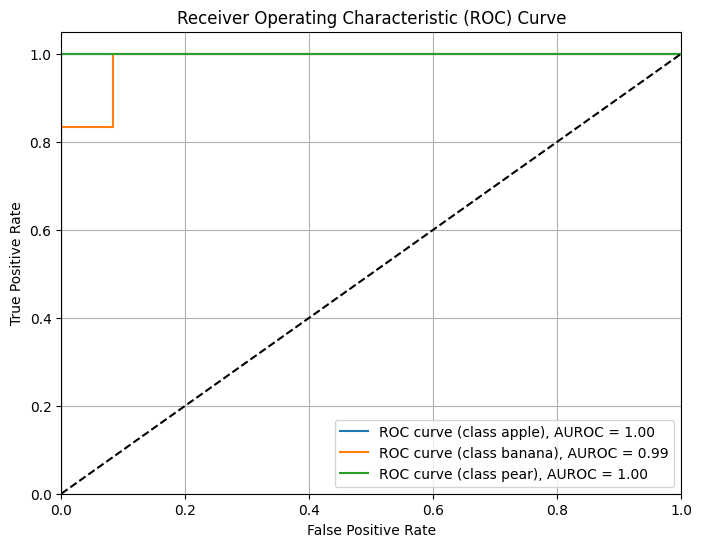

verwachte aantal fouten: 2
Validation loss: 0.24345505237579346
Validation accuracy: 0.9375


In [20]:

print("=====================================")
print("Model evaluatie")
# Laden van het opgeslagen model
model = tf.keras.models.load_model(model_path)

# Compileer het model (als het niet al gecompileerd was)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Evaluatie van het model
test_loss, test_accuracy = model.evaluate(ds_test)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")

# Evaluatie van het model op validatie set
val_loss, val_acc = model.evaluate(ds_validation)
print("Loss: ", val_loss)
print("Accuracy: ", val_acc)

# Voorspel met je model en verzamel labels
y_true = []
y_pred = []

for images, labels in ds_test:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(predictions)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Bereken AUROC
auroc = metrics.roc_auc_score(y_true, y_pred, multi_class='ovo')

print(f"AUROC: {auroc}")

# Plot AUROC curve per klasse
plt.figure(figsize=(8, 6))
for i in range(len(ds_test.class_names)):
    fpr, tpr, _ = metrics.roc_curve(y_true == i, y_pred[:, i])
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve (class {ds_test.class_names[i]}), AUROC = {roc_auc:.2f}')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Verwachte aantal fouten die het mode maakt
y_pred_labels = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_true, y_pred_labels)
expected_errors = np.sum(cm) - np.trace(cm)
print(f"verwachte aantal fouten: {expected_errors}")

print(f"Validation loss: {val_loss}")
print(f"Validation accuracy: {val_acc}")
print("=====================================")


### Verwarringsmatrix

Confusion matrix


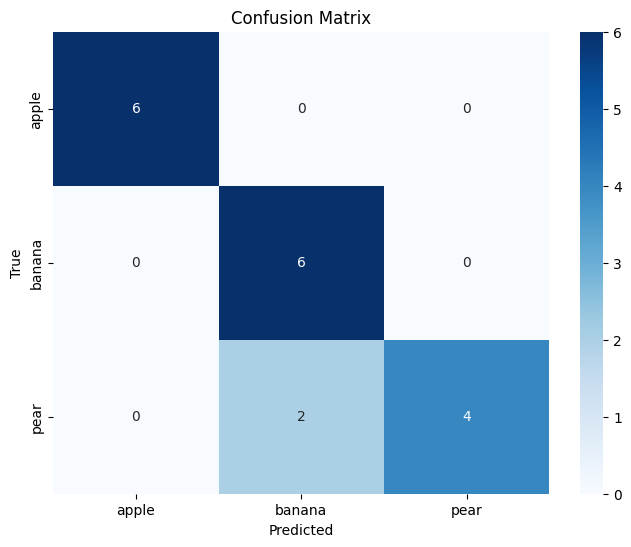

In [22]:
print("=====================================")
print("Confusion matrix")

# Voorbeeld van omzetting naar integer labels als y_pred continue waarden bevat
y_pred_int = np.argmax(y_pred, axis=1)

# Bereken en plot de verwarringsmatrix
cm = confusion_matrix(y_true, y_pred_int)

# Plot de verwarringsmatrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt="d", xticklabels=ds_test.class_names, yticklabels=ds_test.class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("=====================================")

### Overzicht voorspelde data en daadwerkelijke data

Predicted vs True Labels
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


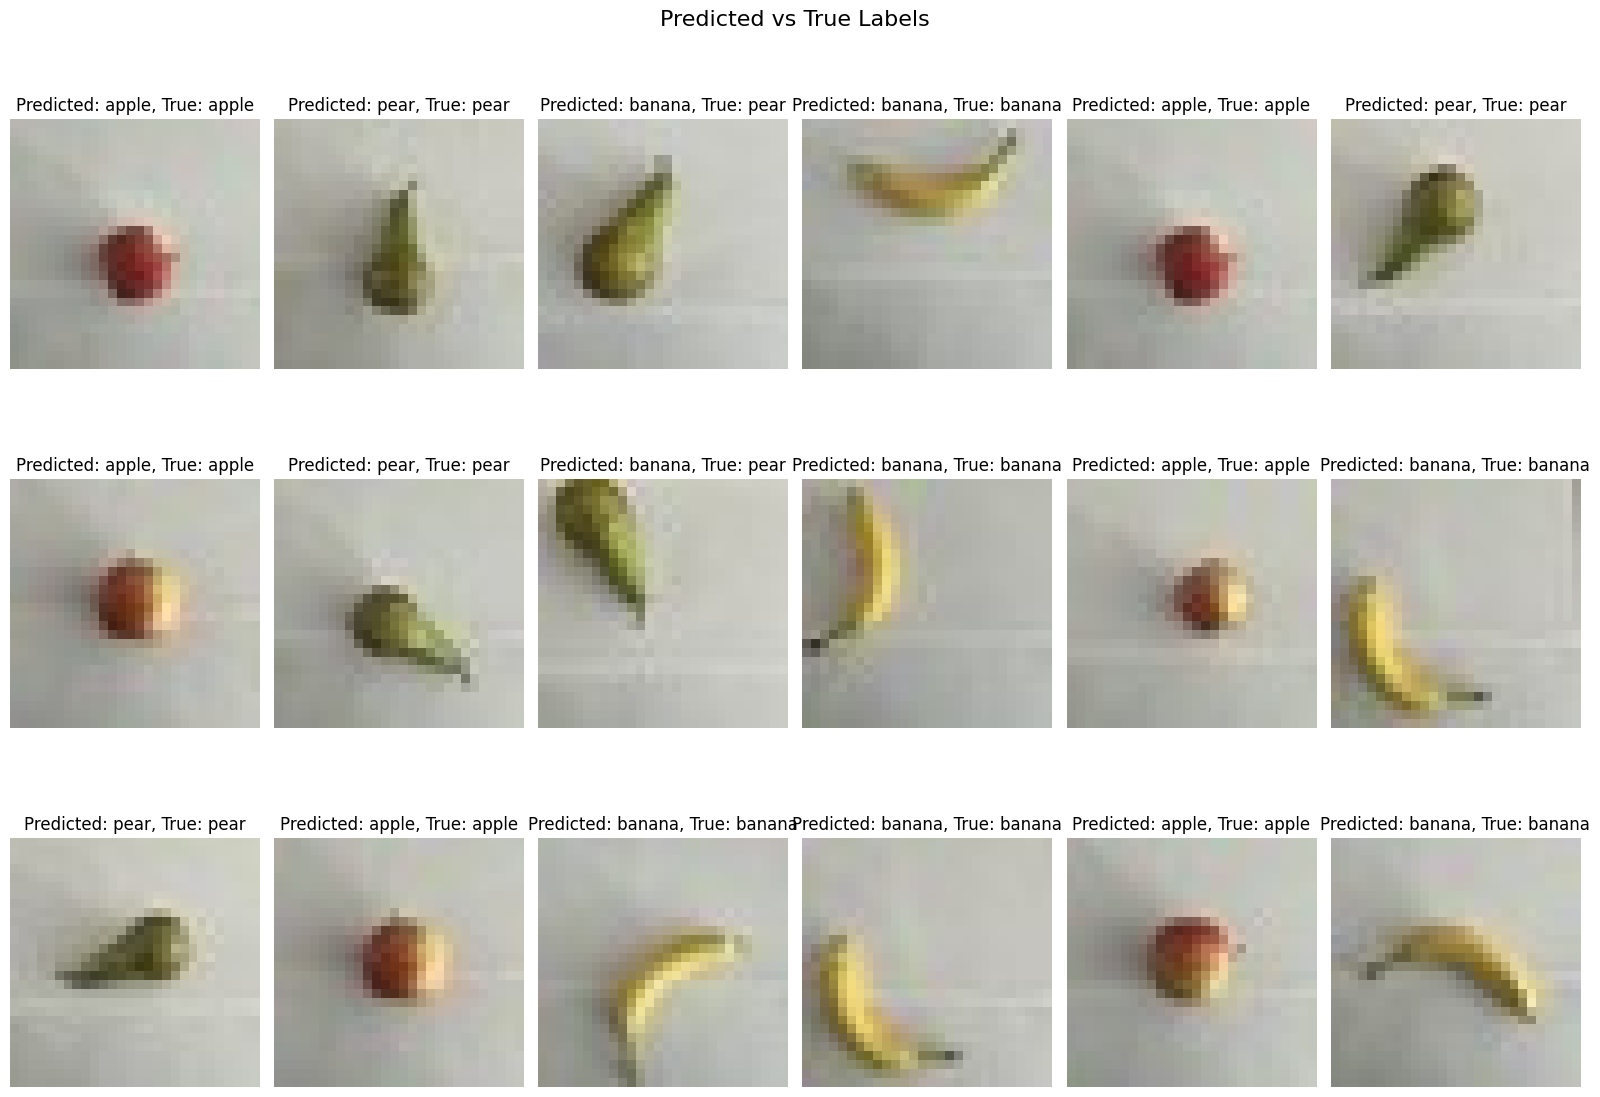

In [23]:
print("=====================================")
print("Predicted vs True Labels")

# Aantal afbeeldingen dat je wilt plotten
num_images_to_plot = 18

# Plot de eerste 18 voorspelde en echte labels verdeeld over 2 batches
plt.figure(figsize=(16, 12))  # Aangepaste figuurgrootte voor bredere afbeeldingen
image_count = 0

for images, labels in ds_test.take(2):  # Neem 2 batches
    predictions = model.predict(images)
    batch_size = images.shape[0]  # Haal de werkelijke batchgrootte op
    for i in range(min(batch_size, num_images_to_plot - image_count)):  # Bereken de juiste range
        ax = plt.subplot(3, 6, image_count + 1)  # Verander naar 3 rijen en 6 kolommen
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Predicted: {ds_test.class_names[np.argmax(predictions[i])]}, True: {ds_test.class_names[labels[i]]}")
        plt.axis("off")
        image_count += 1
        if image_count >= num_images_to_plot:
            break  # Stop de loop als het gewenste aantal afbeeldingen is bereikt

    if image_count >= num_images_to_plot:
        break  # Stop de buitenste lus als het gewenste aantal afbeeldingen is bereikt

plt.suptitle("Predicted vs True Labels", fontsize=16)
plt.tight_layout()
plt.show()

print("=====================================")
